[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building MoGs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.10.2. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

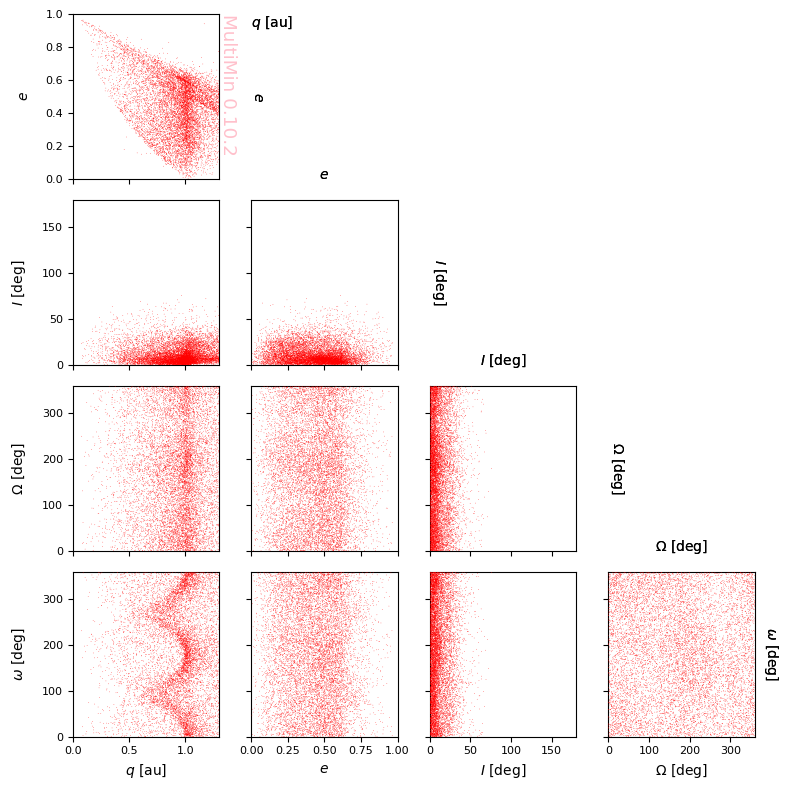

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.MultiPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

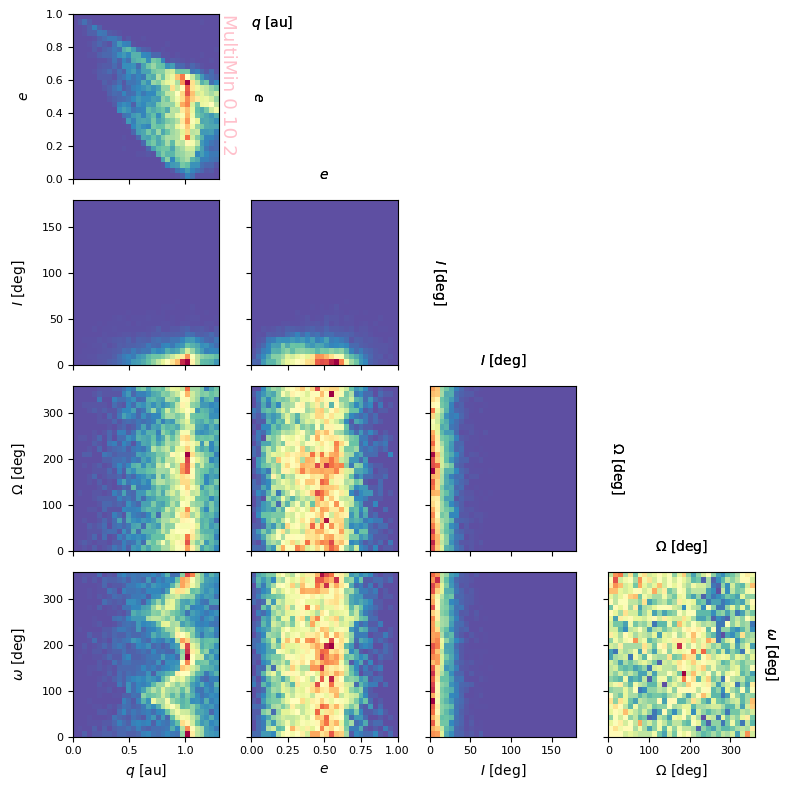

In [5]:
G=mn.MultiPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [6]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

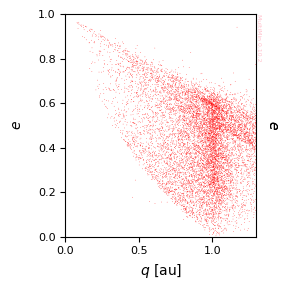

In [7]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [8]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitMoG(data=data_neas_qe, ngauss=1, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(progress=False)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.3042076155744366
FitMoG.fit_data executed in 0.1346118450164795 seconds
Elapsed time since last call: 142.868 ms
-log(L)/N = -0.538631837534648


And check the fit result:

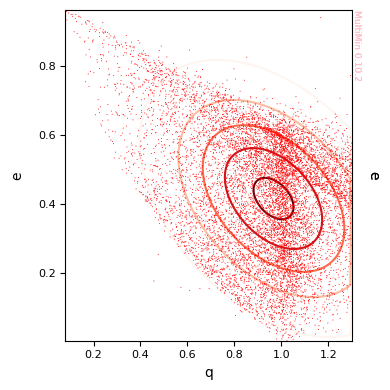

In [9]:
# properties: list of names or dict like MultiPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
pargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
cargs=dict()
G=F_qe_1.plot_fit(
    properties=properties,
    #pargs=hargs,
    pargs=None,
    sargs=sargs,
    cargs=cargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [10]:
F_qe_1.mog.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.966935,0.416309,0.265666,0.18732,-0.420903


We can do it better increasing the number of normals:

In [11]:
t = mn.Util.el_time(0)
F = mn.FitMoG(data=data_neas_qe, ngauss=5, domain=[[0,1.3], [0, 1]])
F.fit_data(advance=50)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 2
Number of dimensions: 10
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.24423897084468318
Iterations:
Iter 0:
	Vars: [-1.5, -1.3, -1.3, -1.3, -1.5, 0.47, 0.14, 0.81, 0.32, 0.96, 0.45, 1, 0.55, 1.2, 0.71, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, 0.73, 0.64, 0.72, 0.4, 1.1]
	LogL/N: 2.0550784892507203


Iter 50:
	Vars: [-2.1, -1.3, -0.88, -0.81, -1.9, 0.93, 0.18, 0.7, 0.38, 1, 0.35, 1.2, 0.5, 0.99, 0.54, -4.3, -4.8, -3.8, -4, -4.5, -4.5, -3.2, -4.1, -4.3, -4.9, -1, -2.1, -1.1, -3.6, 0.51]
	LogL/N: -0.7014878878739209


Iter 100:
	Vars: [-2.2, -1.6, -0.66, -0.68, -1.9, 0.93, 0.17, 0.66, 0.38, 1, 0.34, 1.1, 0.5, 0.97, 0.54, -4.3, -4.9, -4, -4.1, -4.5, -4.5, -3.1, -4.1, -4.2, -5, -0.99, -1.9, -0.71, -3.5, 0.32]
	LogL/N: -0.7045444369420389


Iter 150:
	Vars: [-2.5, -2, 0.13, -0.96, -1.8, 0.75, 0.22, 0.6, 0.46, 1, 0.34, 1.1, 0.5, 1, 0.56, -4.4, -4.8, -4, -4.2, -4.4, -4.2, -3.1, -4, -3.8, -5.2, -2.1, -1.7, -0.48, -4.2, -0.057]
	LogL/N: -0.7086164797887256


Iter 200:
	Vars: [-2.5, -1.8, 0.12, -0.95, -1.8, 0.73, 0.23, 0.63, 0.47, 1, 0.33, 1.3, 0.44, 1, 0.57, -4.2, -4.5, -4, -4.2, -4.4, -4.3, -3, -3.9, -4.2, -5.2, -3.1, -1.6, -0.44, -4.2, -0.4]
	LogL/N: -0.7128434403421979


Iter 250:
	Vars: [-2.4, -1.7, 0.042, -1, -1.8, 0.73, 0.23, 0.65, 0.46, 1, 0.34, 1.2, 0.47, 1, 0.56, -4, -4.4, -4, -4.1, -4.4, -4.3, -3, -3.9, -4, -5.2, -3.4, -1.8, -0.46, -4.2, -0.4]
	LogL/N: -0.7139904542336625


Iter 300:
	Vars: [-2.5, -1.8, -0.019, -1, -1.5, 0.69, 0.25, 0.67, 0.42, 1, 0.33, 1.2, 0.49, 0.98, 0.56, -4, -4.3, -3.9, -4, -4.4, -4.3, -3, -4, -4, -5.1, -3.7, -2.5, -0.42, -4.1, -0.43]
	LogL/N: -0.7146149439271252


Iter 350:
	Vars: [-2.7, -1.6, -0.0023, -1.1, -1.4, 0.64, 0.27, 0.72, 0.36, 1, 0.34, 1.1, 0.52, 0.99, 0.55, -4.2, -4.4, -3.8, -3.8, -4.4, -4.3, -3.1, -4, -3.9, -5, -4, -3, -0.41, -4.1, -0.47]
	LogL/N: -0.7154168363618263


Iter 400:
	Vars: [-2.9, -1.6, 0.011, -1, -1.4, 0.64, 0.28, 0.72, 0.35, 1, 0.34, 1.1, 0.51, 0.99, 0.55, -4.2, -4.4, -3.8, -3.8, -4.4, -4.3, -3.1, -4, -3.9, -5, -4.1, -2.9, -0.46, -4.1, -0.54]
	LogL/N: -0.715623780573818


Iter 450:
	Vars: [-2.9, -1.6, 0.022, -1, -1.4, 0.64, 0.27, 0.73, 0.35, 1, 0.34, 1.1, 0.51, 0.99, 0.55, -4.2, -4.4, -3.8, -3.8, -4.4, -4.3, -3.1, -4, -3.8, -5.1, -4.2, -2.8, -0.47, -4.1, -0.56]
	LogL/N: -0.7156554924688904
Iter 454:
	Vars: [-2.9, -1.6, 0.022, -1, -1.4, 0.64, 0.27, 0.73, 0.35, 1, 0.34, 1.1, 0.51, 0.99, 0.55, -4.2, -4.4, -3.8, -3.8, -4.4, -4.3, -3.1, -4, -3.8, -5.1, -4.2, -2.8, -0.47, -4.1, -0.56]
	LogL/N: -0.7156561771363898
FitMoG.fit_data executed in 22.181917190551758 seconds
Elapsed time since last call: 22.1853 s
-log(L)/N = -0.7156561771363898


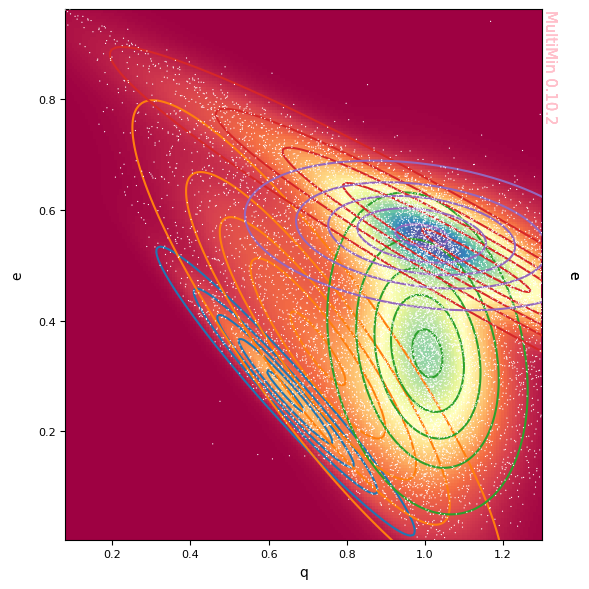

In [12]:
properties = ["q","e"]
sargs = dict(s=0.8,edgecolor='None',color='w')
pargs = dict(cmap='Spectral')
cargs = dict(decomp=True, legend=False)
G=F.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    cargs=cargs,
    figsize=6,
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_decomposition.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [13]:
neas_sample = F.mog.rvs(len(data_neas_qe))

MixtureOfGaussians.rvs executed in 0.6233682632446289 seconds


And plot it:

Text(0.5, 1.0, 'Original data')

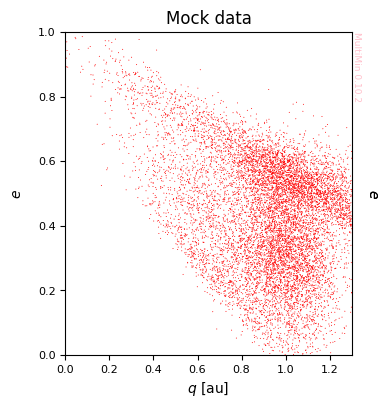

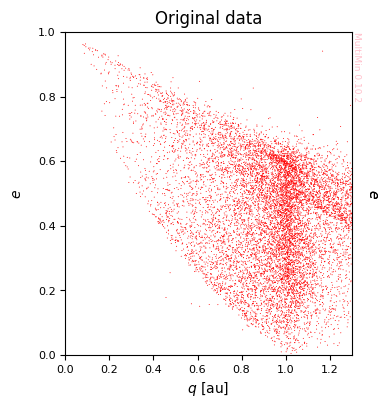

In [14]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.MultiPlot(properties,figsize=4)
G.sample_scatter(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.MultiPlot(properties,figsize=4)
scatter=G.sample_scatter(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [15]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.mog.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
3,0.427166,1.006505,0.340648,0.119455,0.135518,-0.228574
4,0.220070,1.131025,0.508403,0.436770,0.179910,-0.966637
5,0.161081,0.991625,0.553798,0.210751,0.062958,-0.274133
2,0.145687,0.726109,0.349734,0.221202,0.208953,-0.890418
1,0.045995,0.643301,0.272448,0.154171,0.121663,-0.969384


In [16]:
function, mog = F.mog.get_function(properties=properties)

import numpy as np
from multimin import Util

def mog(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.643301
    mu1_e = 0.272448
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.023769, -0.018183], [-0.018183, 0.014802]]
    Z1 = 0.987419
    n1 = Util.tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.726109
    mu2_e = 0.349734
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.04893, -0.041156], [-0.041156, 0.043661]]
    Z2 = 0.951574
    n2 = Util.tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 1.006505
    mu3_e = 0.340648
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.014269, -0.0037], [-0.0037, 0.018365]]
    Z3 = 0.98721
    n3 = Util.tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.131025
    mu4_e = 0.508403
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.190768, -0.075958], [-0.075958, 0.032368]]
    Z4 = 0.64524
    n4 = Util.tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 0.991625
    mu5_e = 0.553798
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.044416, -0.003637], [-0.003637, 0.003964]]
    Z5 = 0

### Fitting other pair of properties

Fitting $q$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 180]]
Log-likelihood per point (-log L/N): 132.44127723865074
FitMoG.fit_data executed in 0.08879303932189941 seconds
-log(L)/N = 3.4592002228143697


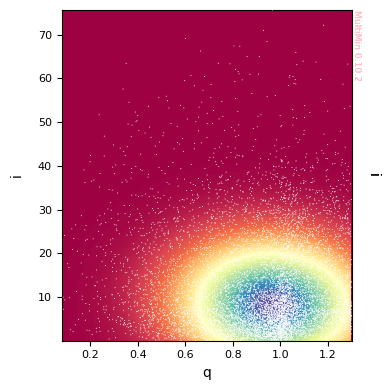

In [17]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitMoG(data=data_neas_qi, ngauss=1, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(progress=False)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
sargs=dict(s=0.5,edgecolor='None',color='w')
pargs=dict(cmap='Spectral')
G=F_qi_1.plot_fit(properties=properties,pargs=pargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1], [0, 180]]
Log-likelihood per point (-log L/N): 135.1873931234
FitMoG.fit_data executed in 0.07167816162109375 seconds
-log(L)/N = 3.2786405117667483


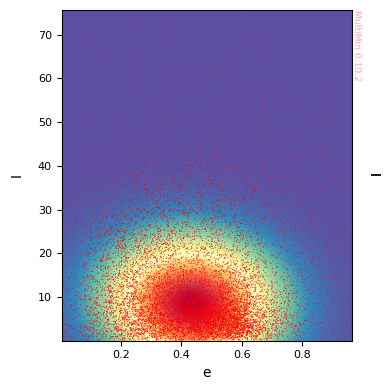

In [18]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitMoG(data=data_neas_ei, ngauss=1, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(progress=False)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [19]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

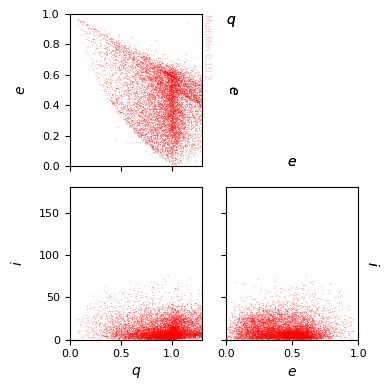

In [20]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.MultiPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.sample_scatter(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 145.4971144234512


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.9690802097320557 seconds
-log(L)/N = -1.697011182642091


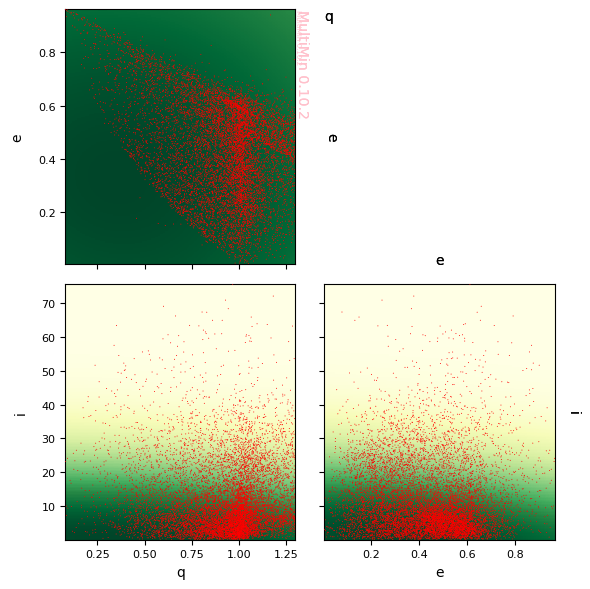

In [21]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    sargs=sargs,
    pargs=pargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

In [22]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.mog.mus[0, 0] + F_qi_1.mog.mus[0, 0]) / 2
mu_e = (F_qe_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 0]) / 2
mu_i = (F_qi_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 1]) / 2
sigma_q = (F_qe_1.mog.sigmas[0, 0] + F_qi_1.mog.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.mog.rhos[0, 0])
rho_qi = float(F_qi_1.mog.rhos[0, 0])
rho_ei = float(F_ei_1.mog.rhos[0, 0])

fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
#fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 145.49711367378723


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.373887300491333 seconds
-log(L)/N = -2.3910773147770743


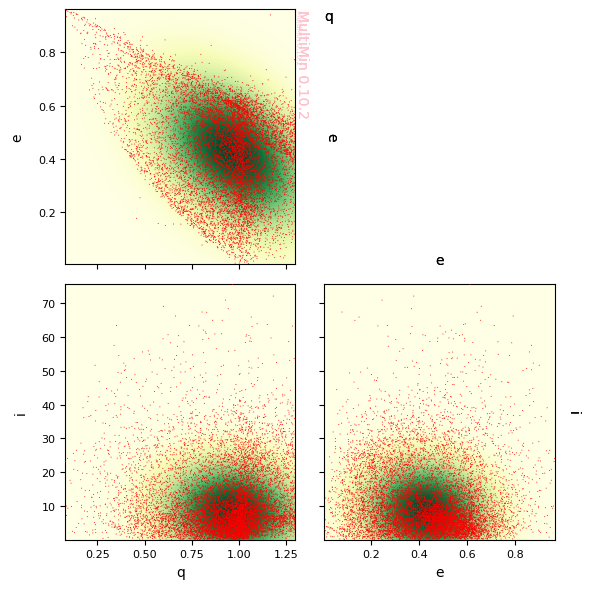

In [23]:
properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Domain: [[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]]
Log-likelihood per point (-log L/N): 335.28981135208335


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 5.620580196380615 seconds


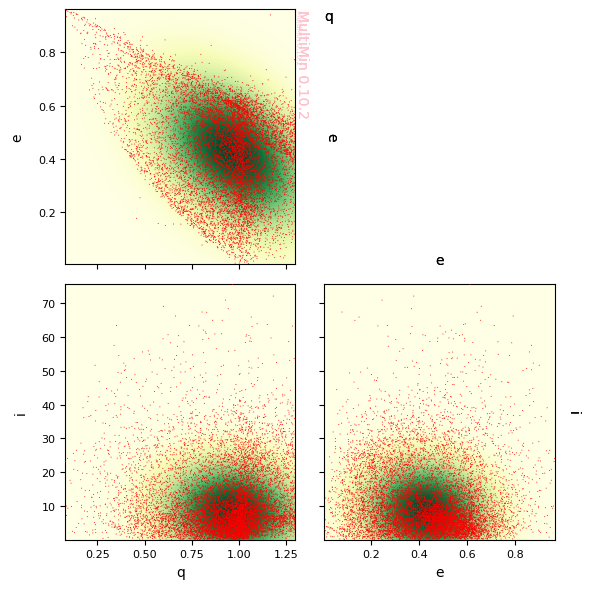

In [24]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=5, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(progress="tqdm")
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the MoG is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the MoG in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [25]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **MultiPlot** (scatter on pairwise panels):

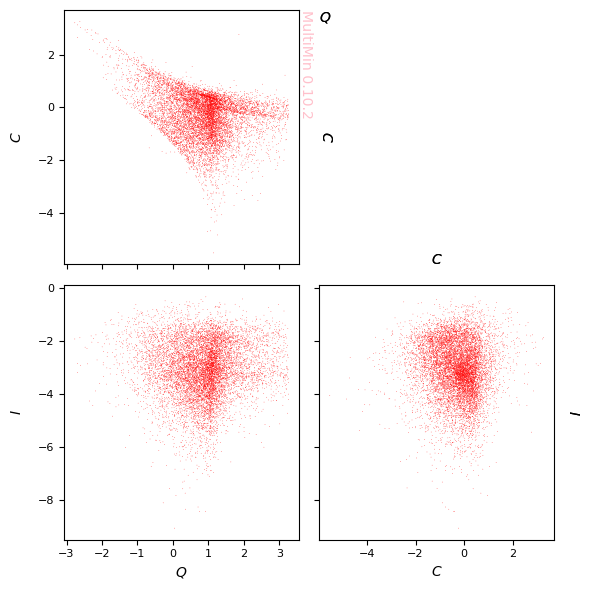

In [26]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.MultiPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

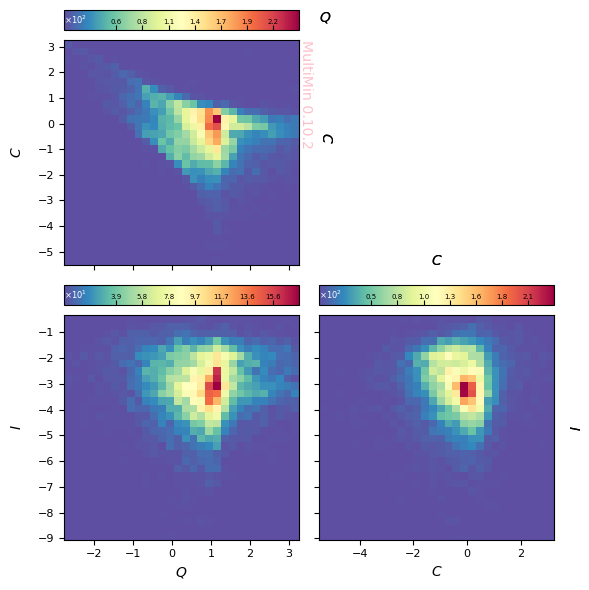

In [27]:
G=mn.MultiPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [28]:
F=mn.FitMoG(data=udata, ngauss=1)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.883064444803155


The fitter holds an initial MoG that will be optimized:

In [29]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.5, 0.5, 0.5]]
    Standard deviations (σ): [[1.0000000000000002, 1.0000000000000002, 1.0000000000000002]]
    Correlation coefficients (ρ): [[0.5, 0.5, 0.5]]

    Covariant matrices (Σ): 
        [[[1.0000000000000004, 0.5000000000000002, 0.5000000000000002], [0.5000000000000002, 1.0000000000000004, 0.5000000000000002], [0.5000000000000002, 0.5000000000000002, 1.0000000000000004]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000004, 0.5000000000000002, 0.5000000000000002, 1.0000000000000004, 0.5000000000000002, 1.0000000000000004]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000002, 1.0000000000000002, 1.000

Run the minimization:

In [30]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False,progress="tqdm")
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.1719038486480713 seconds
Elapsed time since last call: 171.996 ms
-log(L)/N = 3.949406013838397


Inspect the fitted MoG:

In [31]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8475881009326323, -0.3222011692992342, -3.0578141546650075]]
    Standard deviations (σ): [[0.8518159173654706, 0.8610565455094417, 1.0589446065633894]]
    Correlation coefficients (ρ): [[-0.3120338276933964, 0.02493140618209666, -0.07043804015796451]]

    Covariant matrices (Σ): 
        [[[0.7255903570771782, -0.22886485273613238, 0.022488773388602938], [-0.22886485273613238, 0.7414183745646532, -0.06422619285236232], [0.022488773388602938, -0.06422619285236232, 1.1213636797696915]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8475881009326323, -0.3222011692992342, -3.0578141546650075, 0.7255903570771782, -0.22886485273613238, 0.022488773388602938, 0.7414183745646532, -0.06422619285236232, 1.1213636797696915]
        With std. and c

Plot the fit result (fitted sample + data scatter):

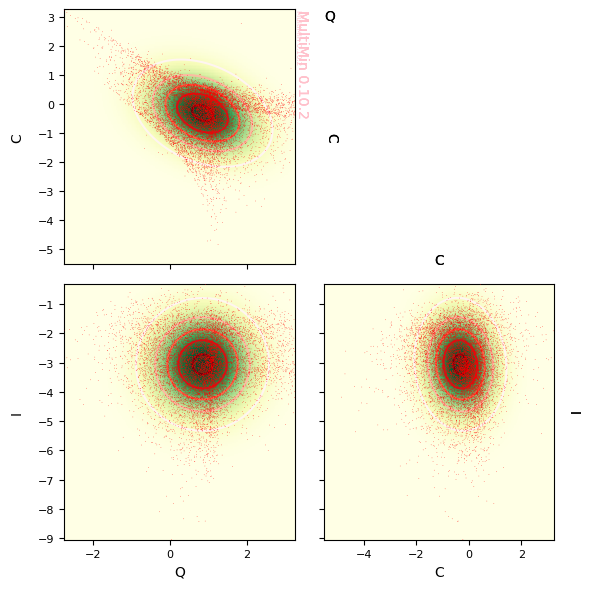

In [32]:
properties=["Q","C","I"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
cargs=dict()
G=F.plot_fit(properties=properties,sargs=sargs,cargs=cargs,pargs=pargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [33]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [34]:
F=mn.FitMoG(f"gallery/{figprefix}_fit-single.pkl")
print(F.mog)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 3.949406013838397
Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8475881009326323, -0.3222011692992342, -3.0578141546650075]]
    Standard deviations (σ): [[0.8518159173654706, 0.8610565455094417, 1.0589446065633894]]
    Correlation coefficients (ρ): [[-0.3120338276933964, 0.02493140618209666, -0.07043804015796451]]

    Covariant matrices (Σ): 
        [[[0.7255903570771782, -0.22886485273613238, 0.022488773388602938], [-0.22886485273613238, 0.7414183745646532, -0.06422619285236232], [0.022488773388602938, -0.06422619285236232, 1.1213636797696915]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8475881009326323, -0.3222011692992

Fit with two Gaussian components for a better likelihood:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.883064444803155


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 1.5192968845367432 seconds
Elapsed time since last call: 1.51941 s
-log(L)/N = 3.8397051604933337
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.40294783687220653, 0.5970521631277935]
    Number of variables: 3
    Averages (μ): [[0.9439963491704774, 0.30585069677169247, -3.144731040165904], [0.7604095826460626, -0.7239270429121842, -3.0101782551865437]]
    Standard deviations (σ): [[1.0641082838719218, 0.543577715881625, 1.001375317053381], [0.6522260234044195, 0.7842921375008977, 1.0924852546143617]]
    Correlation coefficients (ρ): [[-0.7657871324039685, -0.001021688112769703, 0.08322691954043182], [-0.31664631082052386, 0.07779256504692778, -0.10170196259949926]]

    Covariant matrices (Σ): 
        [[[1.1323264398048465, -0.4429508435483299, -0.001088682010856413], [-0.4429508435483299, 0.2954767332030846, 0.04530251857812393], [-0.001088682010856413, 0.04530251857812393, 1.0027525256037593]], [[0.4253

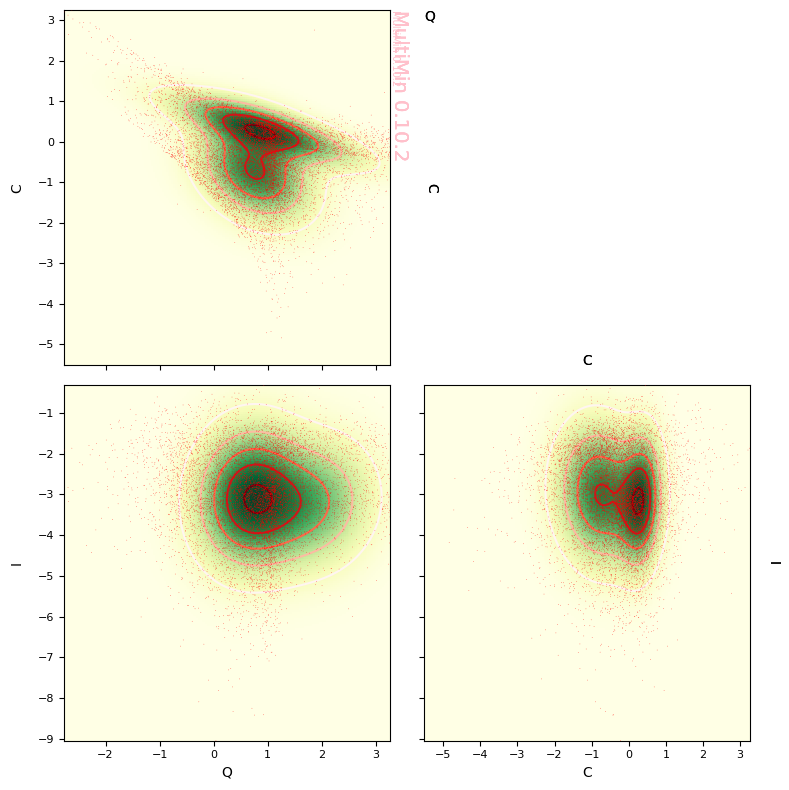

In [35]:
F=mn.FitMoG(data=udata, ngauss=2)

mn.Util.el_time(0)
F.fit_data(progress="tqdm")
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.883064444803155


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 1.0666089057922363 seconds
Elapsed time since last call: 1.06675 s
-log(L)/N = 3.862743110702014
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.2902501603833215, 0.7097498396166785]
    Number of variables: 3
    Averages (μ): [[0.5002220058743478, 0.45361538381984723, -3.416410348173256], [0.960434188412504, -0.6164617810657149, -2.91385892537876]]
    Standard deviations (σ): [[0.9095388234851193, 0.5532918004789412, 1.1416371996618144], [0.7926664220527122, 0.7719986130364531, 0.9833537079109129]]
    Correlation coefficients (ρ): [[-0.8005244120091218, -0.24511793664721826, 0.2908187102629489], [-0.04507010010221302, 0.09784691355859221, -0.017615371123154033]]

    Covariant matrices (Σ): 
        [[[0.8272608714266949, -0.4028562038964717, -0.25452148317241036], [-0.4028562038964717, 0.3061318164772285, 0.18369811078945664], [-0.25452148317241036, 0.18369811078945664, 1.3033354956516696]], [[0.6283200566

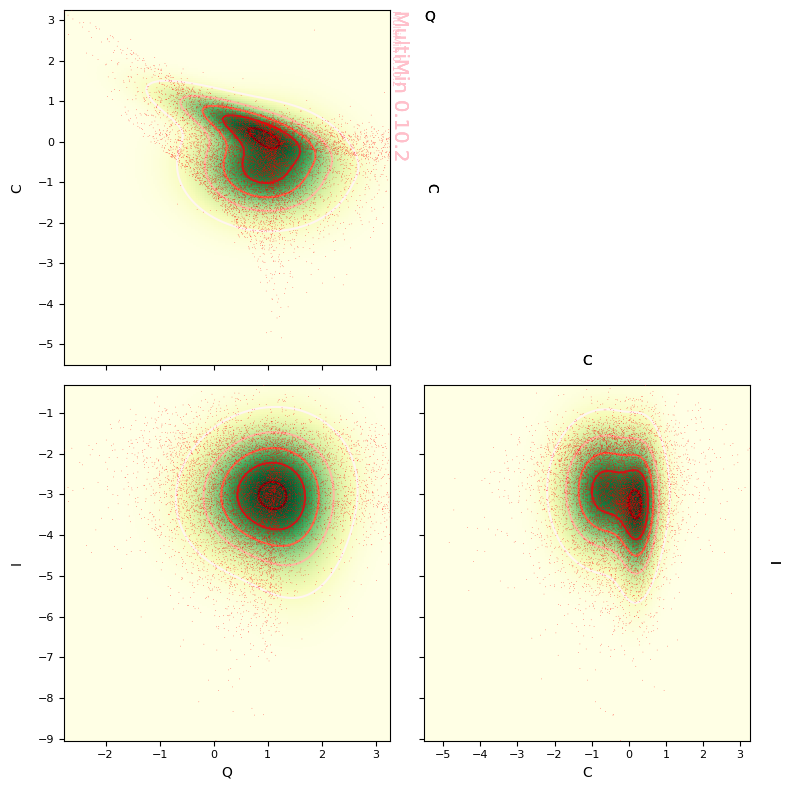

In [36]:
F=mn.FitMoG(data=udata, ngauss=2)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.883064444803155


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 10.892980813980103 seconds
Elapsed time since last call: 10.8932 s
-log(L)/N = 3.696521319598111
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.05816718247177083, 0.15968498647843382, 0.2702770620003774, 0.2737995820335751, 0.238071187015843]
    Number of variables: 3
    Averages (μ): [[1.7406101829729035, -0.363560961685758, -4.002638384075014], [0.9941512395833928, -0.9174259887975359, -2.0379723190732335], [1.153588203901895, 0.27871027804898396, -3.215844663025226], [0.9749889611241335, -0.38550233545303686, -3.3533755141690067], [-0.03732401927676853, -0.42965535209142774, -2.9945008475728865]]
    Standard deviations (σ): [[0.8512962656318472, 0.6256219682419153, 1.6271275363633355], [0.7036220816569818, 0.7307573157432093, 0.4947662360520147], [0.8725225533479672, 0.36864178243096035, 0.8720022361248038], [0.32134471104168755, 0.5261520482732265, 0.8774678423854578], [0.7201390944082693, 1.22341357316

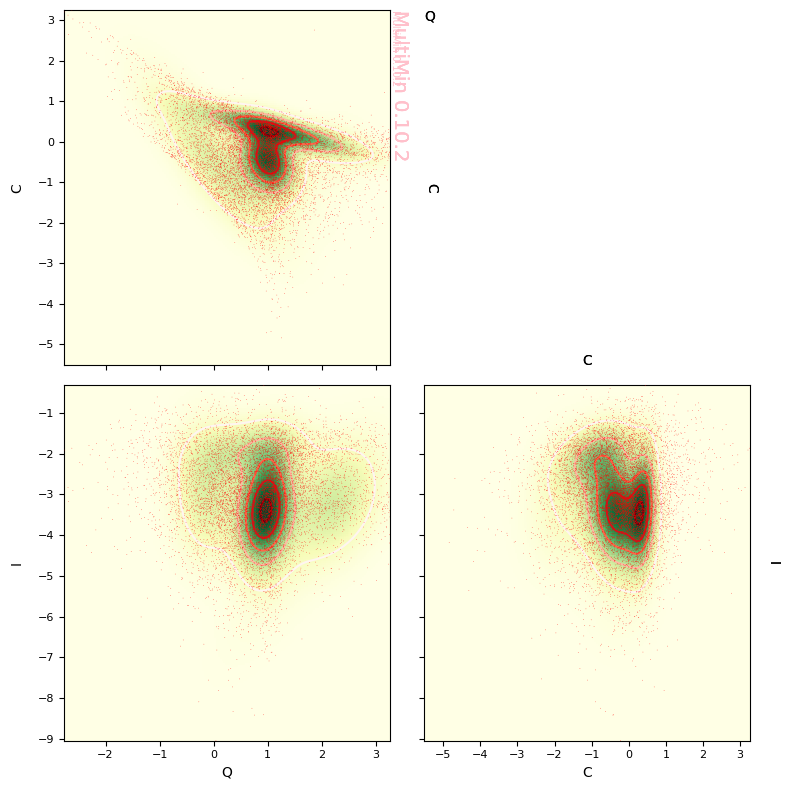

In [37]:
F=mn.FitMoG(data=udata, ngauss=5)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted MoG and comparing to the data:

MixtureOfGaussians.rvs executed in 0.4911651611328125 seconds


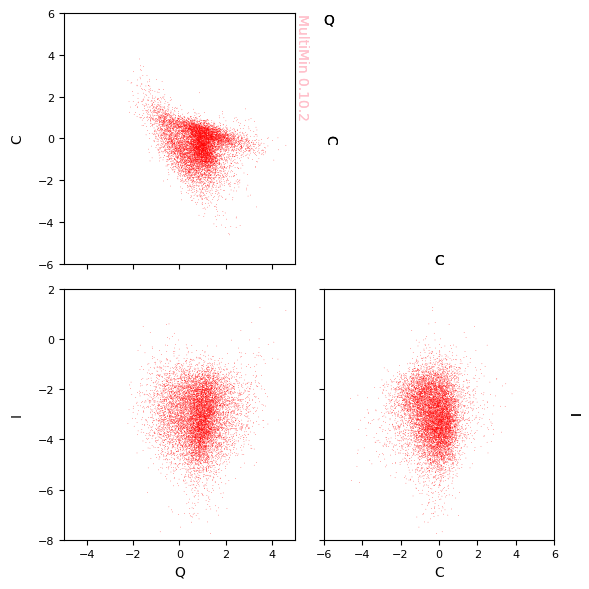

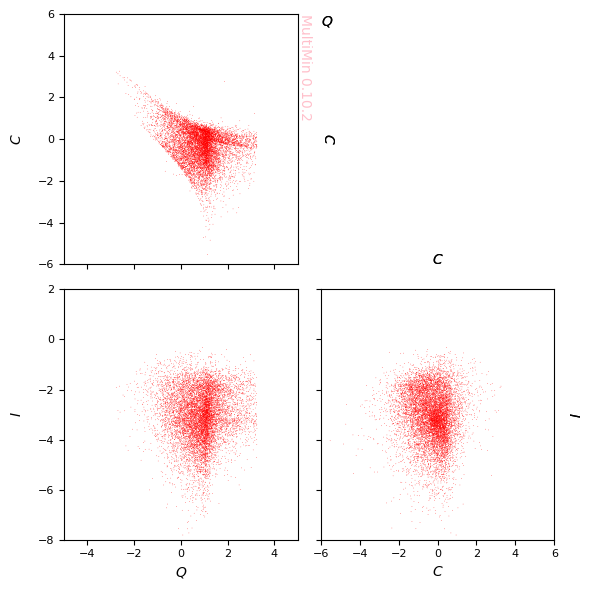

In [38]:
F.mog.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

We can also check the original distribution:

In [39]:
scales=[1.35,1.00,180.0]
usample = F.mog.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

MixtureOfGaussians.rvs executed in 0.6124839782714844 seconds


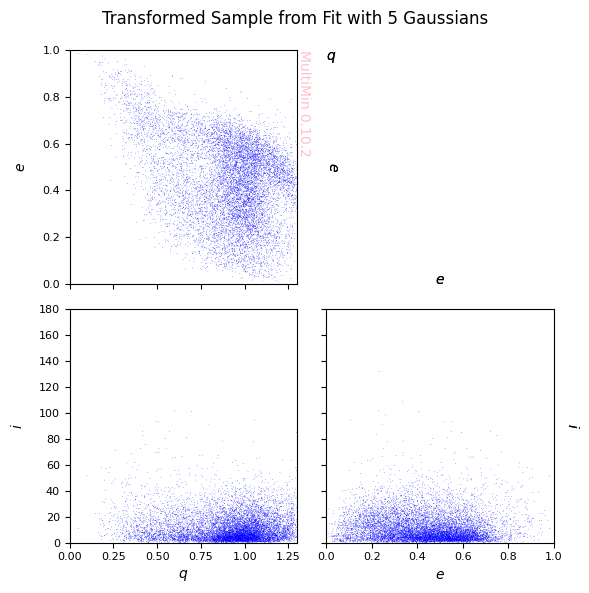

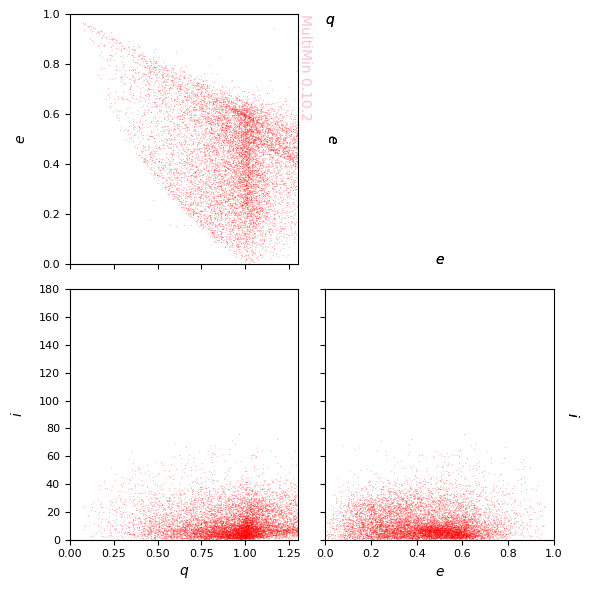

In [40]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.sample_scatter(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.sample_scatter(data_neas_qei,**sargs)

In [41]:
function, mog = F.mog.get_function(properties=properties)

from multimin import Util

def mog(X):

    mu1_q = 1.74061
    mu1_e = -0.363561
    mu1_i = -4.002638
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.724705, -0.003415, 1.11989], [-0.003415, 0.391403, -0.091002], [1.11989, -0.091002, 2.647544]]
    n1 = Util.nmd(X, mu1, Sigma1)

    mu2_q = 0.994151
    mu2_e = -0.917426
    mu2_i = -2.037972
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.495084, -0.211873, 0.004996], [-0.211873, 0.534006, 0.117723], [0.004996, 0.117723, 0.244794]]
    n2 = Util.nmd(X, mu2, Sigma2)

    mu3_q = 1.153588
    mu3_e = 0.27871
    mu3_i = -3.215845
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.761296, -0.250556, 0.133003], [-0.250556, 0.135897, -0.004422], [0.133003, -0.004422, 0.760388]]
    n3 = Util.nmd(X, mu3, Sigma3)

    mu4_q = 0.974989
    mu4_e = -0.385502
    mu4_i = -3.353376
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.103262, -0.052118, 0.070084], [-0.052118, 0.276836, -0.116124], [0.070084, -0.116124, 0.76995]]
    n4 = Util.nmd(X

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga